In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#unzip and add to drive
#!unzip "/content/drive/MyDrive/dlproject/Complex-YOLO.zip" -d "/content/drive/MyDrive/dlproject" 

In [ ]:
from __future__ import division
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import cv2
from scipy import misc
import torch.optim as optim
import torch.utils.data as data
import math
import os
import os.path
import torch.nn.functional as F




In [ ]:
#classes in KITTI DATASET
class_list = ['Car', 'Van' , 'Truck' , 'Pedestrian' , 'Person_sitting' , 'Cyclist' , 'Tram' ]


In [ ]:
file = open("/content/drive/MyDrive/dlproject/training/train.txt","w")


for i in range(6000):
    file_i = str(i).zfill(6)
    file.write(file_i + "\n")
   

file.close()

# **Utils**

Helper functions


In [ ]:


# classes
class_list = ['Car', 'Van' , 'Truck' , 'Pedestrian' , 'Person_sitting' , 'Cyclist' , 'Tram' ]


bc={}
bc['minX'] = 0; bc['maxX'] = 80; bc['minY'] = -40; bc['maxY'] = 40
bc['minZ'] =-2; bc['maxZ'] = 1.25


def removePoints(PointCloud, BoundaryCond):
    
    # Boundary condition
    minX = BoundaryCond['minX'] ; maxX = BoundaryCond['maxX']
    minY = BoundaryCond['minY'] ; maxY = BoundaryCond['maxY']
    minZ = BoundaryCond['minZ'] ; maxZ = BoundaryCond['maxZ']
    
    # Remove the point out of range x,y,z
    mask = np.where((PointCloud[:, 0] >= minX) & (PointCloud[:, 0]<=maxX) & (PointCloud[:, 1] >= minY) & (PointCloud[:, 1]<=maxY) & (PointCloud[:, 2] >= minZ) & (PointCloud[:, 2]<=maxZ))
    PointCloud = PointCloud[mask]

    PointCloud[:,2] = PointCloud[:,2]+2
    return PointCloud

def makeBVFeature(PointCloud_, BoundaryCond, Discretization):
    # 1024 x 1024 x 3
    Height = 1024+1
    Width = 1024+1

    # Discretize Feature Map
    PointCloud = np.copy(PointCloud_)
    PointCloud[:,0] = np.int_(np.floor(PointCloud[:,0] / Discretization))
    PointCloud[:,1] = np.int_(np.floor(PointCloud[:,1] / Discretization) + Width/2)
    
    # sort-3times
    indices = np.lexsort((-PointCloud[:,2],PointCloud[:,1],PointCloud[:,0]))
    PointCloud = PointCloud[indices]

    # Height Map
    heightMap = np.zeros((Height,Width))

    _, indices = np.unique(PointCloud[:,0:2], axis=0, return_index=True)
    PointCloud_frac = PointCloud[indices]
    #some important problem is image coordinate is (y,x), not (x,y)
    heightMap[np.int_(PointCloud_frac[:,0]), np.int_(PointCloud_frac[:,1])] = PointCloud_frac[:,2]


    # Intensity Map & DensityMap
    intensityMap = np.zeros((Height,Width))
    densityMap = np.zeros((Height,Width))
    
    _, indices, counts = np.unique(PointCloud[:,0:2], axis = 0, return_index=True,return_counts = True)
    PointCloud_top = PointCloud[indices]

    normalizedCounts = np.minimum(1.0, np.log(counts + 1)/np.log(64))
    
    intensityMap[np.int_(PointCloud_top[:,0]), np.int_(PointCloud_top[:,1])] = PointCloud_top[:,3]
    densityMap[np.int_(PointCloud_top[:,0]), np.int_(PointCloud_top[:,1])] = normalizedCounts
    """
    plt.imshow(densityMap[:,:])
    plt.pause(2)
    plt.close()
    plt.show()
    plt.pause(2)
    plt.close()
    plt.show(block=False)
    plt.pause(2)
    plt.close()
    plt.imshow(intensityMap[:,:])
    plt.show(block=False)
    plt.pause(2)
    plt.close()
    """
    RGB_Map = np.zeros((Height,Width,3))
    RGB_Map[:,:,0] = densityMap      # r_map
    RGB_Map[:,:,1] = heightMap       # g_map
    RGB_Map[:,:,2] = intensityMap    # b_map
    
    save = np.zeros((512,1024,3))
    save = RGB_Map[0:512,0:1024,:]
    #misc.imsave('test_bv.png',save[::-1,::-1,:])
    #misc.imsave('test_bv.png',save)   
    return save





def get_target(label_file,Tr):
    target = np.zeros([50, 7], dtype=np.float32)
    
    with open(label_file,'r') as f:
        lines = f.readlines()

    num_obj = len(lines)
    index=0
    for j in range(num_obj):
        obj = lines[j].strip().split(' ')
        obj_class = obj[0].strip()
        #print(obj)


        if obj_class in class_list:
             
             t_lidar , box3d_corner = box3d_cam_to_velo(obj[8:], Tr)   # get target  3D object location x,y
             location_x = t_lidar[0][0]          
             location_y = t_lidar[0][1]
             #print(t_lidar)             

             if  (location_x>0) & (location_x<40) & (location_y>-40)  & (location_y<40) :
                  #print(obj_class)
                  target[index][2] = t_lidar[0][0]/40             # make sure target inside the covering area (0,1)
                  target[index][1] = (t_lidar[0][1]+40)/80             ## we should put this in [0,1] ,so divide max_size  80 m


                  obj_width  = obj[9].strip()
                  obj_length = obj[10].strip()
                  target[index][3]=float(obj_width)/80
                  target[index][4]=float(obj_length)/40     # get target width ,length


                  obj_alpha = obj[3].strip()            # get target Observation angle of object, ranging [-pi..pi]
                  target[index][5]=math.sin(float(obj_alpha))    #complex YOLO   Im
                  target[index][6]=math.cos(float(obj_alpha))    #complex YOLO   Re

                  #print(np.arctan2(target[0][4],target[0][5]))
    
                  for i in range(len(class_list)):
                       if obj_class == class_list[i]:     # get target class
                              target[index][0]=i
                  index=index+1

    return target





def box3d_cam_to_velo(box3d, Tr):

    def project_cam2velo(cam, Tr):
        T = np.zeros([4, 4], dtype=np.float32)
        T[:3, :] = Tr
        T[3, 3] = 1
        T_inv = np.linalg.inv(T)
        lidar_loc_ = np.dot(T_inv, cam)
        lidar_loc = lidar_loc_[:3]
        return lidar_loc.reshape(1, 3)

    def ry_to_rz(ry):
        angle = -ry - np.pi / 2

        if angle >= np.pi:
            angle -= np.pi
        if angle < -np.pi:
            angle = 2*np.pi + angle

        return angle

    h,w,l,tx,ty,tz,ry = [float(i) for i in box3d]
    cam = np.ones([4, 1])
    cam[0] = tx
    cam[1] = ty
    cam[2] = tz
    t_lidar = project_cam2velo(cam, Tr)

    Box = np.array([[-l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2],
                    [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2],
                    [0, 0, 0, 0, h, h, h, h]])

    rz = ry_to_rz(ry)

    rotMat = np.array([
        [np.cos(rz), -np.sin(rz), 0.0],
        [np.sin(rz), np.cos(rz), 0.0],
        [0.0, 0.0, 1.0]])

    velo_box = np.dot(rotMat, Box)

    cornerPosInVelo = velo_box + np.tile(t_lidar, (8, 1)).T

    box3d_corner = cornerPosInVelo.transpose()

    return t_lidar , box3d_corner.astype(np.float32)




def load_kitti_calib(calib_file):
    """
    load projection matrix
    """
    with open(calib_file) as fi:
        lines = fi.readlines()
        assert (len(lines) == 8)

    obj = lines[0].strip().split(' ')[1:]
    P0 = np.array(obj, dtype=np.float32)
    obj = lines[1].strip().split(' ')[1:]
    P1 = np.array(obj, dtype=np.float32)
    obj = lines[2].strip().split(' ')[1:]
    P2 = np.array(obj, dtype=np.float32)
    obj = lines[3].strip().split(' ')[1:]
    P3 = np.array(obj, dtype=np.float32)
    obj = lines[4].strip().split(' ')[1:]
    R0 = np.array(obj, dtype=np.float32)
    obj = lines[5].strip().split(' ')[1:]
    Tr_velo_to_cam = np.array(obj, dtype=np.float32)
    obj = lines[6].strip().split(' ')[1:]
    Tr_imu_to_velo = np.array(obj, dtype=np.float32)

    return {'P2': P2.reshape(3, 4),
            'R0': R0.reshape(3, 3),
            'Tr_velo2cam': Tr_velo_to_cam.reshape(3, 4)}






anchors = [[1.08,1.19], [3.42,4.41], [6.63,11.38], [9.42,5.11], [16.62,10.52]]


def bbox_iou(box1, box2, x1y1x2y2=True):
    """
    Returns the IoU of two bounding boxes
    """
    if not x1y1x2y2:
        # Transform from center and width to exact coordinates
        b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
        b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
        b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
        b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2
    else:
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    # get the corrdinates of the intersection rectangle
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    # Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(
        inter_rect_y2 - inter_rect_y1 + 1, min=0
    )
    # Union Area
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

    return iou






def convert2cpu(gpu_matrix):
    return torch.FloatTensor(gpu_matrix.size()).copy_(gpu_matrix)


def convert2cpu_long(gpu_matrix):
    return torch.LongTensor(gpu_matrix.size()).copy_(gpu_matrix)






# Kitty

Load the KITTI dataset for training


In [ ]:
class KittiDataset(torch.utils.data.Dataset):

    def __init__(self, root='/content/drive/MyDrive/dlproject',set='train',type='velodyne_train'):
        self.type = type
        self.root = root
        self.data_path = os.path.join(root, 'training')
        self.lidar_path = os.path.join(self.data_path, "velodyne/")
        self.image_path = os.path.join(self.data_path, "image_2/")
        self.calib_path = os.path.join(self.data_path, "calib/")
        self.label_path = os.path.join(self.data_path, "label_2/")

        with open(os.path.join(self.data_path, '%s.txt' % set)) as f:
            self.file_list = f.read().splitlines()


    def __getitem__(self, i):

        lidar_file = self.lidar_path + '/' + self.file_list[i] + '.bin'
        calib_file = self.calib_path + '/' + self.file_list[i] + '.txt'
        label_file = self.label_path + '/' + self.file_list[i] + '.txt'
        image_file = self.image_path + '/' + self.file_list[i] + '.png'
        #print(self.file_list[i])

        if self.type == 'velodyne_train':

            calib = load_kitti_calib(calib_file)

            
            target = get_target(label_file,calib['Tr_velo2cam'])
            #print(target)
            #print(self.file_list[i])
            
            ################################
            # load point cloud data
            a = np.fromfile(lidar_file, dtype=np.float32).reshape(-1, 4)

            b = removePoints(a,bc)

            data = makeBVFeature(b, bc ,40/512)   # (512, 1024, 3)

            return data , target

        elif self.type == 'velodyne_test':
            NotImplemented

        else:
            raise ValueError('the type invalid')


    def __len__(self):
        return len(self.file_list)




# Region_Loss

In [ ]:
def build_targets(pred_boxes,pred_conf, pred_cls, target, anchors, num_anchors, num_classes, nH, nW, ignore_thres):
    nB = target.size(0)
    nA = num_anchors   #5
    nC = num_classes   #8
    mask = torch.zeros(nB,nA,nH,nW)
    conf_mask  = torch.ones(nB, nA, nH, nW)
    tx         = torch.zeros(nB, nA, nH, nW)
    ty         = torch.zeros(nB, nA, nH, nW) 
    tw         = torch.zeros(nB, nA, nH, nW) 
    tl         = torch.zeros(nB, nA, nH, nW)
    tim        = torch.zeros(nB, nA, nH, nW)
    tre        = torch.zeros(nB, nA, nH, nW)
    tconf      = torch.ByteTensor(nB, nA, nH, nW).fill_(0)
    tcls       = torch.ByteTensor(nB, nA, nH, nW , nC).fill_(0)

    nGT = 0
    nCorrect = 0
    for b in range(nB):
        for t in range(target.shape[1]):
            if target[b][t].sum() == 0:
                continue

            nGT += 1
            # Convert to position relative to box
            gx = target[b, t, 1] * nW
            gy = target[b, t, 2] * nH
            gw = target[b, t, 3] * nW
            gl = target[b, t, 4] * nH
            #gim = target[b][t][5]
            #gre = target[b][t][6]

            # Get grid box indices
            gi = int(gx)
            gj = int(gy)
            # Get shape of gt box
            gt_box = torch.FloatTensor(np.array([0, 0, gw, gl])).unsqueeze(0)
            # Get shape of anchor box
            anchor_shapes = torch.FloatTensor(np.concatenate((np.zeros((len(anchors), 2)), np.array(anchors)), 1))
            # Calculate iou between gt and anchor shapes
            anch_ious = bbox_iou(gt_box, anchor_shapes)
            # Where the overlap is larger than threshold set mask to zero (ignore)
            conf_mask[b, anch_ious > ignore_thres, gj, gi] = 0
            # Find the best matching anchor box
            best_n = np.argmax(anch_ious)
            # Get ground truth box
            gt_box = torch.FloatTensor(np.array([gx, gy, gw, gl])).unsqueeze(0)
            # Get the best prediction
            pred_box = pred_boxes[b, best_n, gj, gi].unsqueeze(0)
            # Masks
            mask[b, best_n, gj, gi] = 1
            conf_mask[b, best_n, gj, gi] = 1
            # Coordinates
            tx[b, best_n, gj, gi] = gx - gi
            ty[b, best_n, gj, gi] = gy - gj
            # Width and height
            tw[b, best_n, gj, gi] = math.log(gw / anchors[best_n][0] + 1e-16)
            tl[b, best_n, gj, gi] = math.log(gl / anchors[best_n][1] + 1e-16)
            # One-hot encoding of label
            target_label = int(target[b, t, 0])
            tcls[b, best_n, gj, gi, target_label] = 1
            tconf[b, best_n, gj, gi] = 1

            # Calculate iou between ground truth and best matching prediction
            iou = bbox_iou(gt_box, pred_box, x1y1x2y2=False)
            pred_label = torch.argmax(pred_cls[b, best_n, gj, gi])
            score = pred_conf[b, best_n, gj, gi]
            if iou > 0.5 and pred_label == target_label and score > 0.5:
                nCorrect += 1

    return nGT, nCorrect, mask, conf_mask, tx, ty, tw, tl, tconf, tcls


class RegionLoss(nn.Module):
    def __init__(self, num_classes=8, num_anchors=5):
        super(RegionLoss, self).__init__()

        self.anchors = anchors
        self.num_anchors = num_anchors
        self.num_classes = num_classes
        self.bbox_attrs = 7+num_classes
        self.ignore_thres = 0.6
        self.lambda_coord = 1

        self.mse_loss = nn.MSELoss(size_average=True)  # Coordinate loss
        self.bce_loss = nn.BCELoss(size_average=True)  # Confidence loss
        self.ce_loss = nn.CrossEntropyLoss()  # Class loss



    def forward(self, x, targets):
        #x : batch_size*num_anchorsx(6+1+num_classes)*H*W    [12,75,16,32]
        #targets :   targets define in utils  get_target function   [12,50,7]

        nA = self.num_anchors     # num_anchors = 5
        nB = x.data.size(0)  # batch_size
        nH = x.data.size(2)  # nH  16
        nW = x.data.size(3)  # nW  32


        # Tensors for cuda support
        FloatTensor = torch.cuda.FloatTensor if x.is_cuda else torch.FloatTensor
        LongTensor = torch.cuda.LongTensor if x.is_cuda else torch.LongTensor
        ByteTensor = torch.cuda.ByteTensor if x.is_cuda else torch.ByteTensor

        prediction = x.view(nB, nA, self.bbox_attrs, nH, nW).permute(0, 1, 3, 4, 2).contiguous()  # prediction [12,5,16,32,15]

        # Get outputs
        x = torch.sigmoid(prediction[..., 0])  # Center x
        y = torch.sigmoid(prediction[..., 1])  # Center y
        w = prediction[..., 2]  # Width
        h = prediction[..., 3]  # Height
        pred_conf = torch.sigmoid(prediction[..., 6])  # Conf
        pred_cls = torch.sigmoid(prediction[..., 7:])  # Cls pred.

        # Calculate offsets for each grid
        grid_x = torch.arange(nW).repeat(nH, 1).view([1, 1, nH, nW]).type(FloatTensor)
        grid_y = torch.arange(nH).repeat(nW, 1).t().view([1, 1, nH, nW]).type(FloatTensor)
        scaled_anchors = FloatTensor([(a_w , a_h ) for a_w, a_h in self.anchors])
        anchor_w = scaled_anchors[:, 0:1].view((1, nA, 1, 1))
        anchor_h = scaled_anchors[:, 1:2].view((1, nA, 1, 1))

        # Add offset and scale with anchors
        pred_boxes = FloatTensor(prediction[..., :4].shape)
        pred_boxes[..., 0] = x.data + grid_x
        pred_boxes[..., 1] = y.data + grid_y
        pred_boxes[..., 2] = torch.exp(w.data) * anchor_w
        pred_boxes[..., 3] = torch.exp(h.data) * anchor_h



        if x.is_cuda:
            self.mse_loss = self.mse_loss.cuda()
            self.bce_loss = self.bce_loss.cuda()
            self.ce_loss = self.ce_loss.cuda()

        nGT, nCorrect, mask, conf_mask, tx, ty, tw, th, tconf, tcls = build_targets(
            pred_boxes=pred_boxes.cpu().data,
            pred_conf=pred_conf.cpu().data,
            pred_cls=pred_cls.cpu().data,
            target=targets.cpu().data,
            anchors=scaled_anchors.cpu().data,
            num_anchors=nA,
            num_classes=self.num_classes,
            nH=nH,
            nW=nW,
            ignore_thres=self.ignore_thres
        )

        nProposals = int((pred_conf > 0.5).sum().item())
        recall = float(nCorrect / nGT) if nGT else 1
        precision = float(nCorrect / nProposals)

        # Handle masks
        mask = Variable(mask.type(ByteTensor))
        conf_mask = Variable(conf_mask.type(ByteTensor))

        # Handle target variables
        tx = Variable(tx.type(FloatTensor), requires_grad=False)
        ty = Variable(ty.type(FloatTensor), requires_grad=False)
        tw = Variable(tw.type(FloatTensor), requires_grad=False)
        th = Variable(th.type(FloatTensor), requires_grad=False)
        tconf = Variable(tconf.type(FloatTensor), requires_grad=False)
        tcls = Variable(tcls.type(LongTensor), requires_grad=False)

        # Get conf mask where gt and where there is no gt
        conf_mask_true = mask
        conf_mask_false = conf_mask - mask

        # Mask outputs to ignore non-existing objects
        loss_x = self.mse_loss(x[mask], tx[mask])
        loss_y = self.mse_loss(y[mask], ty[mask])
        loss_w = self.mse_loss(w[mask], tw[mask])
        loss_h = self.mse_loss(h[mask], th[mask])
        loss_conf = self.bce_loss(pred_conf[conf_mask_false], tconf[conf_mask_false]) + self.bce_loss(
            pred_conf[conf_mask_true], tconf[conf_mask_true]
        )
        loss_cls = (1 / nB) * self.ce_loss(pred_cls[mask], torch.argmax(tcls[mask], 1))
        loss = loss_x + loss_y + loss_w + loss_h + loss_conf + loss_cls

        #print('nGT %d, recall %f, precision %f, proposals %d, loss: x %f, y %f, w %f, h %f, conf %f, cls %f, total %f' % \
         #        (nGT, recall,  precision,  nProposals, loss_x.data, loss_y.data, loss_w.data, loss_h.data, loss_conf.data, loss_cls.data,loss.data))

        return loss



# Complex-YOLO
Model with 18 convolution layers and 5 MaxPool layers, each layer has a Batch Normalization followed by A leaky RELu except the last layer

In [ ]:
def reorg(x):
    stride = 2
    assert(x.data.dim() == 4)
    B = x.data.size(0)
    C = x.data.size(1)
    H = x.data.size(2)
    W = x.data.size(3)
    assert(H % stride == 0)
    assert(W % stride == 0)
    ws = stride
    hs = stride
    x = x.view(B, C, int(H/hs), hs, int(W/ws), ws).transpose(3,4).contiguous()
    x = x.view(B, C, int(H/hs*W/ws), hs*ws).transpose(2,3).contiguous()
    x = x.view(B, C, hs*ws, int(H/hs), int(W/ws)).transpose(1,2).contiguous()
    x = x.view(B, hs*ws*C, int(H/hs), int(W/ws))
    return x



class ComplexYOLO(nn.Module):
    def __init__(self):
        super(ComplexYOLO, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=3,out_channels=24,kernel_size=3,stride=1,padding=1)
        self.bn_1   = nn.BatchNorm2d(num_features=24)
        self.pool_1 = nn.MaxPool2d(2)

        self.conv_2 = nn.Conv2d(in_channels=24,out_channels=48,kernel_size=3,stride=1,padding=1)
        self.bn_2   = nn.BatchNorm2d(num_features=48)
        self.pool_2 = nn.MaxPool2d(2)

        self.conv_3 = nn.Conv2d(in_channels=48,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.bn_3   = nn.BatchNorm2d(num_features=64)
        self.conv_4 = nn.Conv2d(in_channels=64,out_channels=32,kernel_size=1,stride=1,padding=0)
        self.bn_4   = nn.BatchNorm2d(num_features=32)
        self.conv_5 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.bn_5   = nn.BatchNorm2d(num_features=64)
        self.pool_3 = nn.MaxPool2d(2)

        self.conv_6 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1)
        self.bn_6   = nn.BatchNorm2d(num_features=128)
        self.conv_7 = nn.Conv2d(in_channels=128,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.bn_7   = nn.BatchNorm2d(num_features=64)
        self.conv_8 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1)
        self.bn_8   = nn.BatchNorm2d(num_features=128)
        self.pool_4 = nn.MaxPool2d(2)

        self.conv_9  = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1)
        self.bn_9    = nn.BatchNorm2d(num_features=256)
        self.conv_10 = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=1,stride=1,padding=0)
        self.bn_10   = nn.BatchNorm2d(num_features=256)
        self.conv_11 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride=1,padding=1)
        self.bn_11   = nn.BatchNorm2d(num_features=512)
        self.pool_5  = nn.MaxPool2d(2)

        self.conv_12 = nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride=1,padding=1)
        self.bn_12   = nn.BatchNorm2d(num_features=512)
        self.conv_13 = nn.Conv2d(in_channels=512,out_channels=512,kernel_size=1,stride=1,padding=0)
        self.bn_13   = nn.BatchNorm2d(num_features=512)
        self.conv_14 = nn.Conv2d(in_channels=512,out_channels=1024,kernel_size=3,stride=1,padding=1)
        self.bn_14   = nn.BatchNorm2d(num_features=1024)
        self.conv_15 = nn.Conv2d(in_channels=1024,out_channels=1024,kernel_size=3,stride=1,padding=1)
        self.bn_15   = nn.BatchNorm2d(num_features=1024)
        self.conv_16 = nn.Conv2d(in_channels=1024,out_channels=1024,kernel_size=3,stride=1,padding=1)
        self.bn_16   = nn.BatchNorm2d(num_features=1024)

        self.conv_17 = nn.Conv2d(in_channels=2048,out_channels=1024,kernel_size=3,stride=1,padding=1)
        self.bn_17   = nn.BatchNorm2d(num_features=1024)
        self.conv_18 = nn.Conv2d(in_channels=1024,out_channels=75,kernel_size=1,stride=1,padding=0)

        self.relu = nn.ReLU(inplace=True)

    def forward(self,x):
        x = self.relu(self.bn_1(self.conv_1(x)))
        x = self.pool_1(x)
        
        x = self.relu(self.bn_2(self.conv_2(x)))
        x = self.pool_2(x)

        x = self.relu(self.bn_3(self.conv_3(x)))
        x = self.relu(self.bn_4(self.conv_4(x)))
        x = self.relu(self.bn_5(self.conv_5(x)))
        x = self.pool_3(x)

        x = self.relu(self.bn_6(self.conv_6(x)))
        x = self.relu(self.bn_7(self.conv_7(x)))
        x = self.relu(self.bn_8(self.conv_8(x)))
        x = self.pool_4(x)
        
        x = self.relu(self.bn_9(self.conv_9(x)))
        route_1 = x            # 12 layer
        reorg_result = reorg(route_1)
        
        x = self.relu(self.bn_10(self.conv_10(x)))
        x = self.relu(self.bn_11(self.conv_11(x)))
        x = self.pool_5(x)

        x = self.relu(self.bn_12(self.conv_12(x)))
        x = self.relu(self.bn_13(self.conv_13(x)))
        x = self.relu(self.bn_14(self.conv_14(x)))
        x = self.relu(self.bn_15(self.conv_15(x)))
        x = self.relu(self.bn_16(self.conv_16(x)))

        x = torch.cat((reorg_result,x),1)
        x = self.relu(self.bn_17(self.conv_17(x)))
        x = self.conv_18(x)

        return x

In [ ]:
model=ComplexYOLO()
model.cuda()
model

ComplexYOLO(
  (conv_1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (bn_4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

# Train

In [ ]:

import time
batch_size=32

# dataset
dataset=KittiDataset(root='/content/drive/MyDrive/dlproject',set='train')
data_loader = data.DataLoader(dataset, batch_size, shuffle=True,pin_memory=True,num_workers=4)

model = ComplexYOLO()
model.cuda()

# define optimizer
optimizer = optim.Adam(model.parameters())

# define loss function
region_loss = RegionLoss(num_classes=8, num_anchors=5)

lossl=[]
c=0

for epoch in range(101):
   start=time.time()
   for batch_idx, (rgb_map, target) in enumerate(data_loader):          
          optimizer.zero_grad()

          rgb_map = rgb_map.view(rgb_map.data.size(0),rgb_map.data.size(3),rgb_map.data.size(1),rgb_map.data.size(2))
          output = model(rgb_map.float().cuda())

          loss = region_loss(output,target)
          

          loss.backward()
          optimizer.step()

   if (epoch % 2 == 0):
       torch.save(model, "ComplexYOLO_epoch"+str(epoch))
   c=c+1
   print(c)
   lossl.append(loss)
   end=time.time()
   print("Time for epoch {} is {} with loss {}".format(epoch+1,(end-start/60.0),loss))    

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:173: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:174: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:175: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py

1
Time for epoch 0 is 1580981220.0650406 with loss 1.136518120765686
2
Time for epoch 1 is 1580981632.5840263 with loss 0.9074435234069824
3
Time for epoch 2 is 1580982046.7056108 with loss 0.8614804744720459
4
Time for epoch 3 is 1580982465.046965 with loss 0.8973052501678467
5
Time for epoch 4 is 1580982887.1141968 with loss 0.9465278387069702
6
Time for epoch 5 is 1580983299.6566477 with loss 0.6788968443870544
7
Time for epoch 6 is 1580983713.9436116 with loss 1.285749912261963
8
Time for epoch 7 is 1580984134.142567 with loss 0.7804110050201416
9
Time for epoch 8 is 1580984560.9258692 with loss 0.7364298105239868
10
Time for epoch 9 is 1580984982.462145 with loss 0.5182375907897949
11
Time for epoch 10 is 1580985410.137557 with loss 0.8805631399154663
12
Time for epoch 11 is 1580985828.0143454 with loss 0.6175538897514343
13
Time for epoch 12 is 1580986247.755204 with loss 0.8127908110618591
14
Time for epoch 13 is 1580986661.903984 with loss 0.4443184435367584
15
Time for epoch 1

In [ ]:
for l in range(len(lossl)):
  lossl[l]=lossl[l].cpu()

Plot of Loss vs Epochs





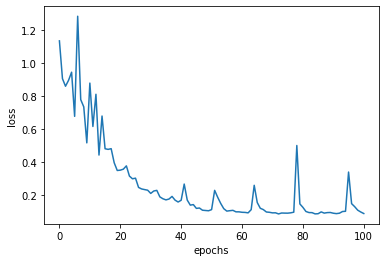

In [ ]:
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(lossl)
plt.show()

As we can see that because of the dataset, we have an overfitting problem hence we use the early stopping technique and take the model saved from the 62nd epoch


# Eval
function to get and draw the predicted classification bounding boxes along with the appropriate labels

In [ ]:
from progressbar import ProgressBar
pbar=ProgressBar()
import imageio
from google.colab.patches import cv2_imshow

def drawRect(img, pt1, pt2, pt3, pt4, color, lineWidth):
    cv2.line(img, pt1, pt2, color, lineWidth)
    cv2.line(img, pt2, pt3, color, lineWidth)
    cv2.line(img, pt3, pt4, color, lineWidth)
    cv2.line(img, pt1, pt4, color, lineWidth)


def get_region_boxes(x, conf_thresh, num_classes, anchors, num_anchors):
    if x.dim() == 3:
        x = x.unsqueeze(0)

    assert (x.size(1) == (7 + num_classes) * num_anchors)

    nA = num_anchors  # num_anchors = 5
    nB = x.data.size(0)
    nC = num_classes  # num_classes = 8
    nH = x.data.size(2)  # nH  16
    nW = x.data.size(3)  # nW  32

    # Tensors for cuda support
    FloatTensor = torch.cuda.FloatTensor if x.is_cuda else torch.FloatTensor
    LongTensor = torch.cuda.LongTensor if x.is_cuda else torch.LongTensor
    ByteTensor = torch.cuda.ByteTensor if x.is_cuda else torch.ByteTensor

    prediction = x.view(nB, nA, 7+num_classes, nH, nW).permute(0, 1, 3, 4, 2).contiguous()

    # Get outputs
    x = torch.sigmoid(prediction[..., 0])  # Center x
    y = torch.sigmoid(prediction[..., 1])  # Center y
    w = prediction[..., 2]  # Width
    h = prediction[..., 3]  # Height
    pred_conf = torch.sigmoid(prediction[..., 6])  # Conf
    pred_cls = torch.sigmoid(prediction[..., 7:])  # Cls pred.

    # Calculate offsets for each grid
    grid_x = torch.arange(nW).repeat(nH, 1).view([1, 1, nH, nW]).type(FloatTensor)
    grid_y = torch.arange(nH).repeat(nW, 1).t().view([1, 1, nH, nW]).type(FloatTensor)
    scaled_anchors = FloatTensor([(a_w , a_h ) for a_w, a_h in anchors])
    anchor_w = scaled_anchors[:, 0:1].view((1, nA, 1, 1))
    anchor_h = scaled_anchors[:, 1:2].view((1, nA, 1, 1))

    # Add offset and scale with anchors
    pred_boxes = FloatTensor(prediction.shape)
    pred_boxes[..., 0] = x.data + grid_x
    pred_boxes[..., 1] = y.data + grid_y
    pred_boxes[..., 2] = torch.exp(w.data) * anchor_w
    pred_boxes[..., 3] = torch.exp(h.data) * anchor_h

    pred_boxes[..., 6] = pred_conf
    pred_boxes[..., 7:(7 + nC) ] = pred_cls

    pred_boxes = convert2cpu(pred_boxes.transpose(0, 1).contiguous().view(-1, (7 + nC)))  # torch.Size([2560, 15])
    
    all_boxes = []
    for i in range(2560):
        cls=torch.argmax(pred_boxes[i][7:15])
        if cls==0:
            conf_thresh=0.7
        elif cls==3 or cls==5:
            conf_thresh=0.5
        else:
            conf_thresh=0.5
        #print("conf_thresh=",conf_thresh)    
        if pred_boxes[i][6] > conf_thresh:
            all_boxes.append(pred_boxes[i])
            # print(pred_boxes[i])
    return all_boxes


# classes
# class_list = ['Car', 'Van' , 'Truck' , 'Pedestrian' , 'Person_sitting' , 'Cyclist' , 'Tram' ]
colour_list = [(255,0,0),(0,255,0),(0,0,255),(255,255,0),(0,255,255),(255,0,255),(0,255,200)]


bc = {}
bc['minX'] = 0;
bc['maxX'] = 80;
bc['minY'] = -40;
bc['maxY'] = 40
bc['minZ'] = -2;
bc['maxZ'] = 1.25
region_loss = RegionLoss(num_classes=8, num_anchors=5)

#This is for evaluatiing images of particular range
for file_i in pbar(range(6030,6230)):
    #print("epoch=",file_i)
    start=time.time()
    test_i = str(file_i).zfill(6)

    lidar_file = '/content/drive/MyDrive/dlproject/training/velodyne/' + test_i + '.bin'
    calib_file = '/content/drive/MyDrive/dlproject/training/calib/' + test_i + ".txt"
    label_file = '/content/drive/MyDrive/dlproject/training/label_2/' + test_i + ".txt"
#for running on the testing images that do not have labels
#    lidar_file = '/content/drive/MyDrive/dlproject/testing/velodyne/' + test_i + '.bin'
#    calib_file = '/content/drive/MyDrive/dlproject/testing/calib/' + test_i + ".txt"


    # load target data
    calib = load_kitti_calib(calib_file)
    #comment the line below if using testing dataset as there is no target
    target = get_target(label_file, calib['Tr_velo2cam'])
    #print(target)

    # load point cloud data
    a = np.fromfile(lidar_file, dtype=np.float32).reshape(-1, 4)
    b = removePoints(a, bc)
    rgb_map = makeBVFeature(b, bc, 40 / 512)
   
    imageio.imwrite('/content/drive/MyDrive/dlproject/training/results/eval_bv.png', (rgb_map*255).astype(np.uint8))

    # load trained model  and  forward
    input = torch.from_numpy(rgb_map)  # (512, 1024, 3)
    input = input.reshape(1, 3, 512, 1024)
    model = torch.load('/content/drive/MyDrive/dlproject/training/ComplexYOLO_epoch62')
    model.cuda()
    output = model(input.float().cuda())  # torch.Size([1, 75, 16, 32])
   


    # eval result
    conf_thresh = 0.7
  
    num_classes = int(8)
    num_anchors = int(5)
    img = cv2.imread('/content/drive/MyDrive/dlproject/training/results/eval_bv.png')

    all_boxes = get_region_boxes(output, conf_thresh, num_classes, anchors, num_anchors)

    for i in range(len(all_boxes)):
        pred_img_y = int(all_boxes[i][0] * 1024.0 / 32.0)  # 32 cell = 1024 pixels
        pred_img_x = int(all_boxes[i][1] * 512.0 / 16.0)  # 16 cell = 512 pixels
        pred_img_width = int(all_boxes[i][2] * 1024.0 / 32.0)  # 32 cell = 1024 pixels
        pred_img_height = int(all_boxes[i][3] * 512.0 / 16.0)  # 16 cell = 512 pixels

        rect_top1 = int(pred_img_y - pred_img_width / 2)
        rect_top2 = int(pred_img_x - pred_img_height / 2)
        rect_bottom1 = int(pred_img_y + pred_img_width / 2)
        rect_bottom2 = int(pred_img_x + pred_img_height / 2)
        
        index=torch.argmax(all_boxes[i][7:15])
        #drawing classifciation boxes with appropriate labels
        cv2.rectangle(img, (rect_top1, rect_top2), (rect_bottom1, rect_bottom2),colour_list[torch.argmax(all_boxes[i][7:15])] ,1)
        (test_width, text_height), baseline = cv2.getTextSize(class_list[index],cv2.FONT_HERSHEY_PLAIN,0.75, 1)
        cv2.rectangle(img, (rect_top1, rect_top2), (rect_top1+test_width, rect_top2-text_height-baseline),colour_list[index] ,thickness=cv2.FILLED)
        cv2.putText(img, class_list[index], (rect_top1, rect_top2 - baseline), cv2.FONT_HERSHEY_PLAIN, 0.75, (0, 0, 0), 1)


    #code for generating the actual bounding boxes if using training data
    # for j in range(50):
    #      if target[j][1] == 0:
    #          break
    #      img_y = int(target[j][1] * 1024.0)  # 32 cell = 1024 pixels
    #      img_x = int(target[j][2] * 512.0)  # 16 cell = 512 pixels
    #      img_width = int(target[j][3] * 1024.0)  # 32 cell = 1024 pixels
    #      img_height = int(target[j][4] * 512.0)  # 16 cell = 512 pixels
    
    #      rect_top1 = int(img_y - img_width / 2)
    #      rect_top2 = int(img_x - img_height / 2)
    #      rect_bottom1 = int(img_y + img_width / 2)
    #      rect_bottom2 = int(img_x + img_height / 2)
    #      cv2.rectangle(img, (rect_top1, rect_top2), (rect_bottom1, rect_bottom2), (255 ,255, 255), 1)

    
    #cv2_imshow(img)
    imageio.imwrite('/content/drive/MyDrive/dlproject/training/label_3/eval_bv' + test_i + '.png', img)
    end=time.time()
    #print("time taken in this epoch=",(end-start)/60.0)
